# B220 平台使用vision library IP: thresholding (color threshoding)
bd design   
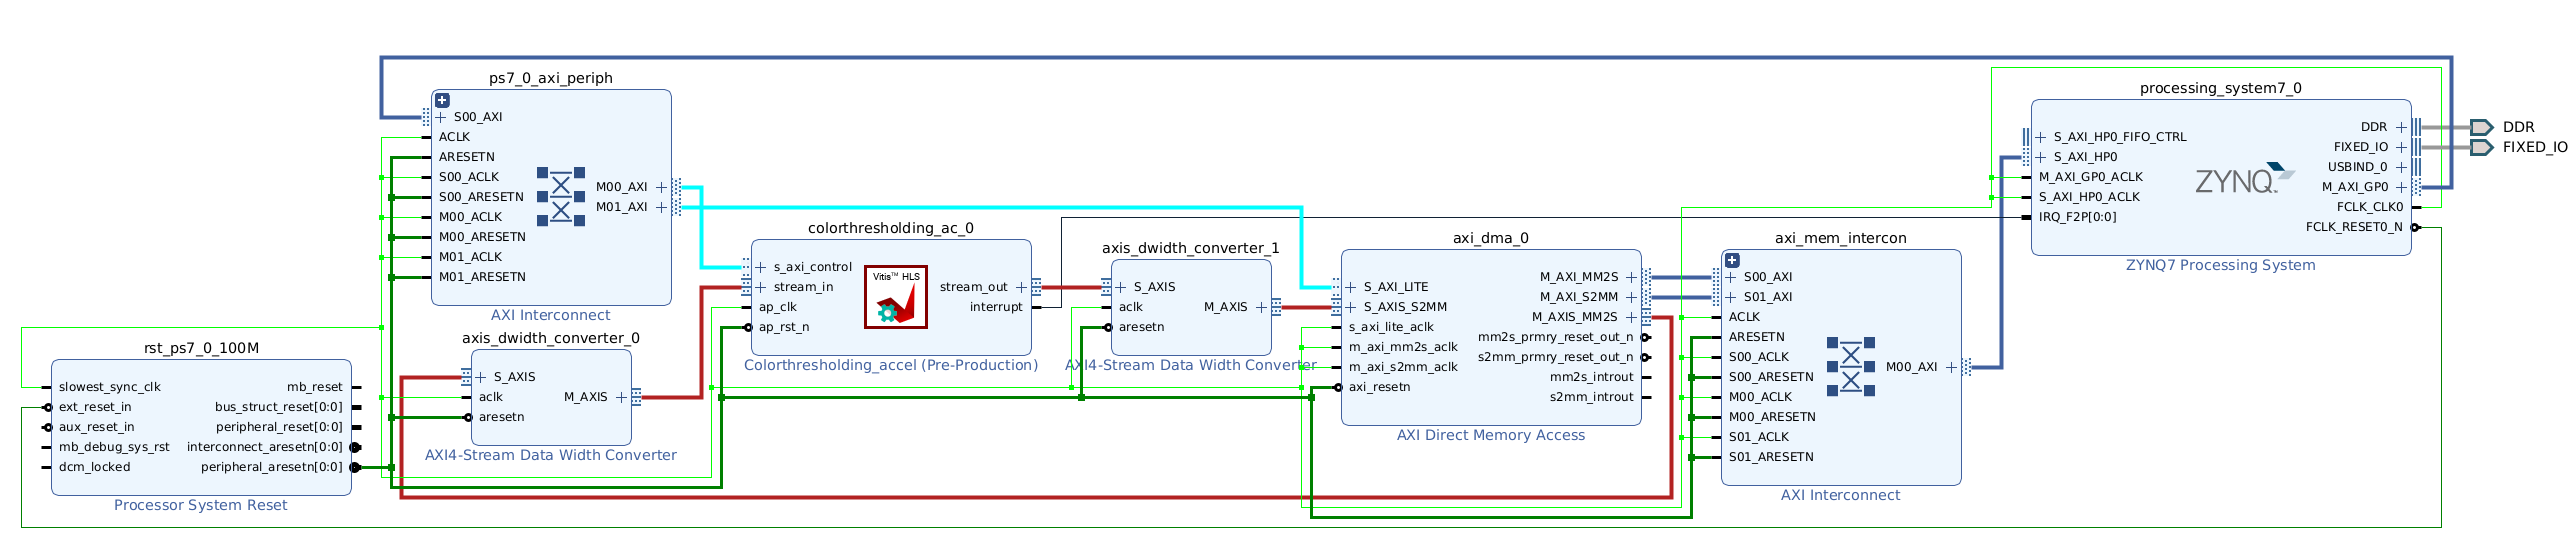
dma configure   
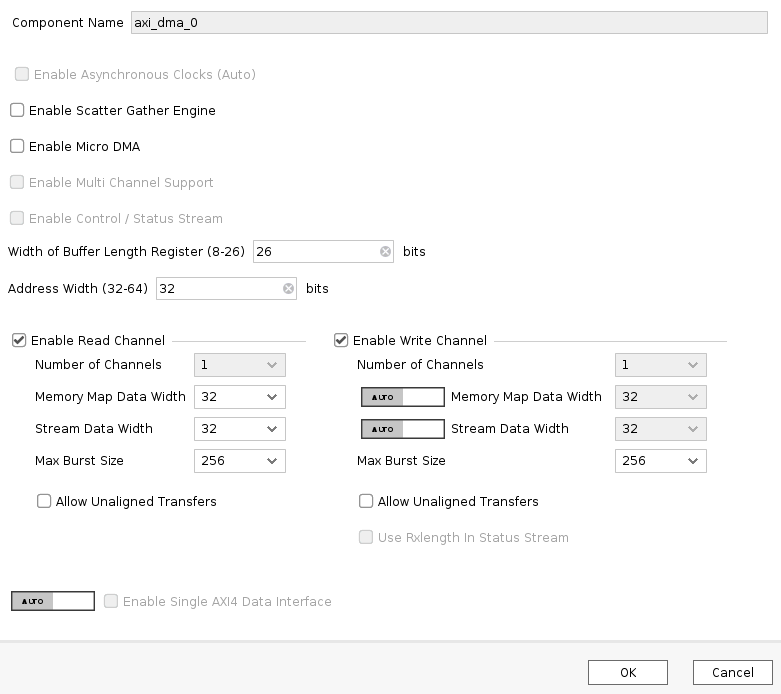

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

In [2]:
thresh_design = Overlay("./overlay/kern_threshhold.bit")

In [4]:
dma = thresh_design.axi_dma_0
thresh_core = thresh_design.colorthresholding_ac_0

In [5]:
thresh_core.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  Memory_lower_threshold = Register(value=0),
  Memory_upper_threshold = Register(value=0),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}

In [6]:
lower_thresh = np.array([136, 87, 111, 25, 52, 72, 94, 80, 2], np.uint8)  # red_lower 136, 87, 111; green_lower 25, 52, 72; blue_lower 94, 80, 2
upper_thresh = np.array([180, 255, 255, 102, 255, 255, 120, 255, 255], np.uint8) # red_upper 180, 255, 255; green_upper 102, 255, 255; blue_upper 120, 255, 255

In [7]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

<Figure size 864x576 with 0 Axes>

In [8]:
image_path = "image/sahara-2k.jpg"
original_image = Image.open(image_path)

Image size: 1920x1080 pixels.


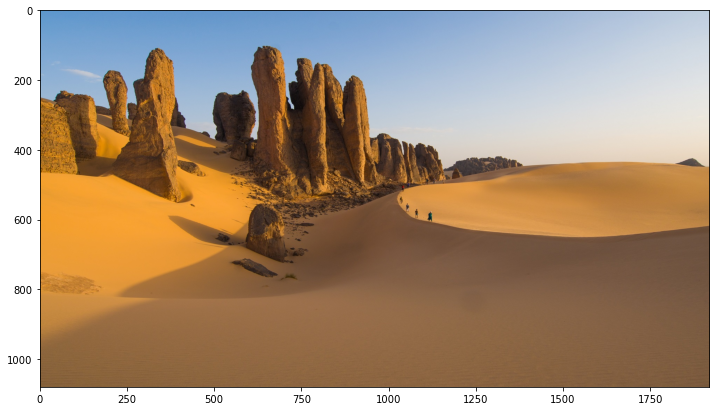

In [9]:
width, height = original_image.size
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(original_image)

In [10]:
in_buffer = allocate(shape=(height, width, 3), dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(height, width, 3), dtype=np.uint8, cacheable=1)

In [11]:
in_buffer[:] = original_image

In [12]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    thresh_core.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [13]:
thresh_core.register_map.rows = width
thresh_core.register_map.cols = height
thresh_core.register_map.Memory_lower_threshold = lower_thresh.all()
thresh_core.register_map.Memory_upper_threshold = upper_thresh.all()

In [14]:
run_kernel()

In [15]:
proced_image = Image.fromarray(out_buffer)

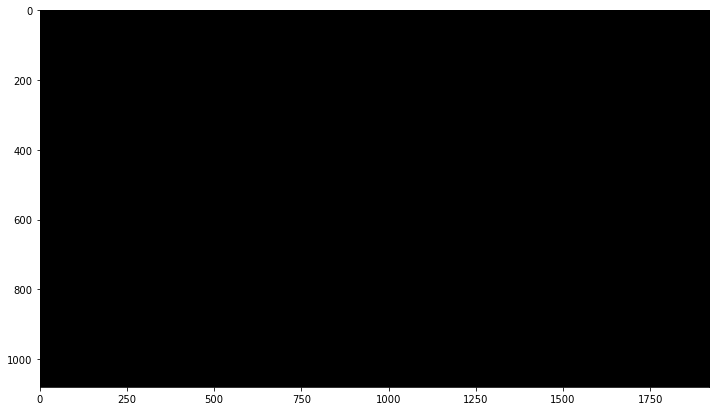

In [16]:
plt.figure(figsize=(12, 10));
_ = plt.imshow(proced_image)